# [Solved] Lab 3: A *whirlwind tour* of `PyTorch` for Deep Learning

Advanced Topics in Machine Learning -- Spring 2024, UniTS

<a target="_blank" href="https://colab.research.google.com/github/emaballarin/adv-ml-units/blob/main/notebooks/AdvML_UniTS_2023_Lab_03_DL_with_PyTorch.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

**NOTE:** This notebook is the same as the *non-solved* version.

### Training a simple *Convolutional Neural Network* on the *MNIST* dataset

`PyTorch` is a Python/C++-based *Deep Learning* and *scientific computing* package that mainly provides two high-level features:
    - **Tensor computation** (like `NumPy`) with strong GPU acceleration;
    - **Deep neural networks** built on a tape-based **autodiff/autograd** system.

The flexibility of `PyTorch` and its *Pythonic* interfaces make it the most widely adopted framework for research and development, both in academia and industry.

For more info, you can have a look at the [official documentation](https://pytorch.org/docs/stable/index.html) or refer to [this book](https://isip.piconepress.com/courses/temple/ece_4822/resources/books/Deep-Learning-with-PyTorch.pdf).


In the following *Lab*, we will learn how to define, train and evaluate a *Neural Network* model in PyTorch. We will use a simple *Convolutional Neural Network* as an example, and we will train it on the *MNIST* dataset.


In [1]:
from tqdm.auto import trange

import numpy as np

import torch as th
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt

#### Hyperparameters & co. (pt. 1)
We collect here all different *choices* that will potentially yield a significant impact on the learned model.

In [2]:
BATCH_SIZE = 32
data_transforms = (
    transforms.ToTensor()
)  # Convert data to PyTorch tensor form and linearly shrink them to [0, 1] range

#### Getting and loading the data
There are potentially other -- more *handcrafted* -- ways to load the data. However, it is always a good practice to rely on `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` classes, as they provide many useful abstractions and  functionalities, such as automated *batching*, *shuffling*, loading *parallelization* and *data augmentation* (`transforms`).

In [3]:
train_dataset = datasets.MNIST(
    root="./data", train=True, transform=data_transforms, download=True
)
test_dataset = datasets.MNIST(
    root="./data", train=False, transform=data_transforms, download=True
)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 9912422/9912422 [00:03<00:00, 2563819.91it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 18096159.82it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2297201.79it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5455477.88it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw


#### Visualizing the data
Let's have a look at some of the images in the dataset.

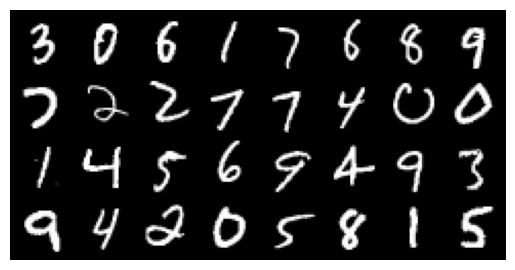

In [4]:
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# Get some random training images
dataiter = train_loader.__iter__()
images, labels = dataiter.__next__()

# Show images
imshow(torchvision.utils.make_grid(images))

#### Printing data shapes

In [5]:
print(
    f"Image data shape is: {images.shape}  i.e.: batch_size × channels × height × width"
)
print(f"Label data shape is: {labels.shape}  i.e.: batch_size × 0-dimensional tensor")

Image data shape is: torch.Size([32, 1, 28, 28])  i.e.: batch_size × channels × height × width
Label data shape is: torch.Size([32])  i.e.: batch_size × 0-dimensional tensor


#### Defining the model

In `PyTorch`, we define a model by subclassing the `nn.Module` class and defining the `forward` method. The `forward` method is where we define the *computation* that happens at every *forward pass* of the model.

Except for extreme corner-cases, the backward pass is automatically defined by `PyTorch` *autograd* system and gradients are obtained efficiently whenever needed.

`PyTorch` modules are *transparent* with respect to batch sizes, i.e. we can use the same model to process a single sample or a batch of samples, without worrying about the exact batch size.

In [6]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # Convolution: BSx1x28x28 => BSx32x26x26
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)

        # BSx(26*26*32) => BSx128
        self.d1 = nn.Linear(26 * 26 * 32, 128)

        # BSx128 => BSx10
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolution: BSx1x28x28 => BSx32x26x26
        x = self.conv1(x)

        # Activation functions are (almost always) applied element-wise
        x = F.relu(x)

        # Flattening: BSx(32x26x26) => BSx(32*26*26)
        x = x.flatten(start_dim=1)

        # Linear layer, i.e. vanilla matrix multiplication:
        # BSx(32*26*26) => BSx128
        x = self.d1(x)
        x = F.relu(x)

        # Linear layer
        # BSx(32*26*26) => BSx128
        logits = self.d2(x)

        # Softmax computation
        out = F.softmax(logits, dim=1)

        return out

#### Model instantiation and test with a single batch
We haven't trained the model yet, so it's not going to give us good results. However, we can still test it on a single batch of data to see if it works from the implementation viewpoint.

In [7]:
model = MyModel()
out = model(images)
print(f"Output shape is: {out.shape}  i.e.: batch_size x num_classes")

Output shape is: torch.Size([32, 10])  i.e.: batch_size x num_classes


In [8]:
def get_batch_accuracy(logit, target):
    """Obtain accuracy for one batch of data"""
    corrects = (th.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects / target.size(0)
    return accuracy.item()

In [9]:
print(f"Accuracy on the single batch just used: {get_batch_accuracy(out, labels)}%")

Accuracy on the single batch just used: 6.25%


In [10]:
# Device selection
device = th.device("cuda" if th.cuda.is_available() else "cpu")

model = (
    MyModel()
)  # Re-instantiate the model to reset the weights/gradients. Weights are initialized by default according to Kaiming He et al. (2015) | https://arxiv.org/abs/1502.01852
model = model.to(device)  # Move the model to the selected device

print(f"Using device: {device}")

Using device: cuda


#### Hyperparameters & co. (pt. 2)

In [11]:
num_epochs = 5  # Number of times the whole (training) dataset is used for training
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)

#### Training loop

In [12]:
for epoch in trange(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = (
        model.train()
    )  # Set the model to training mode: relevant for dropout, batchnorm, etc.

    # Actual (batch-wise) training step
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass + (automated) BackProp + Loss computation
        logits = model(images)
        loss = criterion(logits, labels)

        optimizer.zero_grad()  # Reset the gradients to zero: otherwise they accumulate!
        loss.backward()  # Backpropagation

        # Update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_batch_accuracy(logits, labels)

    model.eval()
    print(
        f"Epoch: {epoch+1} | Loss: {train_running_loss/i} | Train Accuracy: {train_acc/i}"
    )

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | Loss: 1.6157033972068429 | Train Accuracy: 84.89861259338313
Epoch: 2 | Loss: 1.4931081186109316 | Train Accuracy: 97.12346584845251
Epoch: 3 | Loss: 1.483023848515819 | Train Accuracy: 98.03228388473853
Epoch: 4 | Loss: 1.4782261118181488 | Train Accuracy: 98.52754802561365
Epoch: 5 | Loss: 1.4758261710627993 | Train Accuracy: 98.71931696905015


#### Test loop

In [13]:
test_acc = 0.0
for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_batch_accuracy(outputs, labels)

print(f"Test Accuracy: {test_acc/i}")

Test Accuracy: 98.4375
